<a href="https://colab.research.google.com/github/TheVioletRaven/NSE_OU/blob/master/Casus_Open_Universiteit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Notebook gemaakt door: Aukje Reina van Montfort (1704095), Silas Dannulis (2100940), Niema Mahmoudi (1807633) en Viktor Wenemoser (2101260)***

## Library imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns 
from sklearn.decomposition import PCA # wordt gebruikt voor dimensie reductie (data preparatie)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # wordt gebruikt voor normalisatie (data preparatie)
from scipy.stats import zscore # Wordt gebruikt 2 om outliers te verwijderen (data preparatie)
from sklearn.cluster import KMeans # Voor clusteranalyse
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest # Voor verwijdering outliers

In [5]:
df = 'NSE_Instellingsbestand_scaled.csv'
# Laad datasets
df_imputed = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

In [29]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

def remove_outliers(scaled_data):
    # IsolationForest model for outlier detection
    iso = IsolationForest(contamination=0.05)  # Adjust the contamination as necessary
    yhat = iso.fit_predict(scaled_data)
    
    # Select all rows that are not outliers
    mask = yhat != -1
    scaled_data_no_outliers = scaled_data[mask]
    
    return scaled_data_no_outliers

def process_pca(df, explained_variance_threshold=0.95):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Outlier removal on scaled data
    scaled_data_no_outliers = remove_outliers(scaled_data)
    
    pca = PCA()
    pca_result = pca.fit(scaled_data_no_outliers)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(scaled_data_no_outliers))
    
    return pca_df, cumulative_variance, n_components, scaled_data_no_outliers, pca_result

Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best Score: -0.20798850134857214


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (64,), 'mlpclassifier__solver': 'sgd'}
Mean Squared Error op de testset: 0.17607413647851727
Model accuracy op de testset: 0.8239258635214828
R² op de testset: -0.4786913191712565
Cross-Validation Scores: [0.82210526 0.79662803 0.79662803 0.79978925 0.80716544]
Gemiddelde Cross-Validation Score: 0.8044632022627697


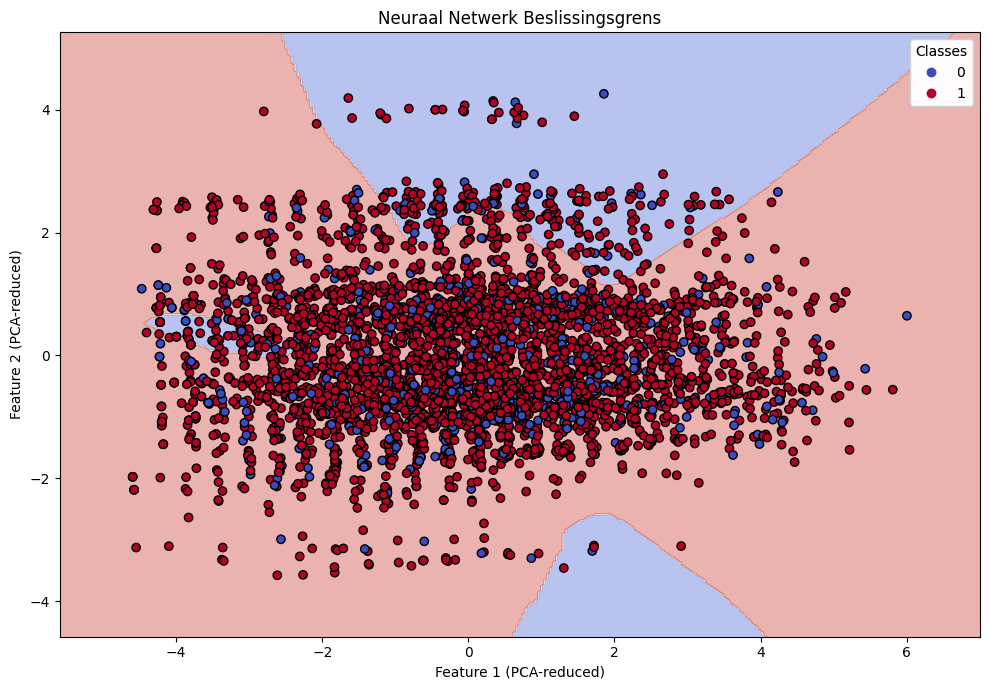

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

df = 'NSE_Instellingsbestand_scaled.csv'
# Laad datasets
df_imputed = pd.read_csv(df)

# Definiëren van de tevredenheidskolommen (hier moeten de juiste kolomnamen komen uit jouw dataset)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Relevante kolommen selecteren voor het proces
relevant_columns_nn = satisfaction_columns + ['Weegfactor', 'Jaar', 'CrohoNaamActueel_B Bedrijfskunde', 'CrohoNaamActueel_B Informatica', 
                                              'CrohoNaamActueel_B Informatiekunde', 'CrohoNaamActueel_B Milieu-natuurwetenschappen', 
                                              'CrohoNaamActueel_B Psychologie', 'CrohoNaamActueel_B Rechtsgeleerdheid']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df_imputed[relevant_columns_nn].dropna()

# Data splitsen in kenmerken (X) en doelvariabelen (y) - we gebruiken één tevredenheidskolom
X = filtered_data_nn.drop(columns=['TEVREDENHEIDALGEMEEN_01'])
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# Convert the target variable to binary
y = (y >= y.median()).astype(int)

# Outliers verwijderen en schalen
def remove_outliers(scaled_data):
    iso = IsolationForest(contamination=0.05)
    yhat = iso.fit_predict(scaled_data)
    mask = yhat != -1
    scaled_data_no_outliers = scaled_data[mask]
    return scaled_data_no_outliers

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_no_outliers = remove_outliers(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_no_outliers, y[:X_scaled_no_outliers.shape[0]], test_size=0.2, random_state=42)

# PCA reduceren naar 2 componenten voor visualisatie
pca_visual = PCA(n_components=2)
X_train_pca_visual = pca_visual.fit_transform(X_train)
X_test_pca_visual = pca_visual.transform(X_test)

# Pipeline maken met MLPClassifier
pipeline = make_pipeline(MLPClassifier(random_state=42, max_iter=2000, tol=1e-6, activation="relu", learning_rate_init=0.01, learning_rate='adaptive', hidden_layer_sizes=[16, 16], solver="adam"))

# Hyperparameterrooster definiëren
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__solver': ['adam', 'sgd'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(accuracy_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'Model accuracy op de testset: {accuracy}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Visualisatie van het neurale netwerk
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots
xx, yy = np.meshgrid(
    np.linspace(X_train_pca_visual[:, 0].min() - 1, X_train_pca_visual[:, 0].max() + 1, 300),
    np.linspace(X_train_pca_visual[:, 1].min() - 1, X_train_pca_visual[:, 1].max() + 1, 300)
)
D = np.c_[xx.ravel(), yy.ravel()]

# Voorspellingen maken over de mesh grid met het visuele PCA-model
Z = best_model.predict(pca_visual.inverse_transform(D))
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_pca_visual[:, 0], X_train_pca_visual[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Classes")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens")
ax2.set_xlabel('Feature 1 (PCA-reduced)')
ax2.set_ylabel('Feature 2 (PCA-reduced)')

plt.tight_layout()
plt.show()